In [1]:
push!(LOAD_PATH,"../../../ExoJulia/")
push!(LOAD_PATH,".")

using Exojulia
using PyPlot

include("aimee.jl")

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


est_burnin (generic function with 1 method)

### Let's try to recover a sinusoidal signal from messy data.  First, we'll make a model function that will allow us to fit for an amplitude and some arbitrary phase offset.

---

Note that for aimee, the model must have the same parameter form as the one below to give the user the means to define any sort of model.

In [2]:
function test_model(data::Array{Float64,2},params::Vector)
    # Data one will be time
    return params[1].*sin(data[:,1] .- params[2])
end

test_model (generic function with 1 method)

### Let's write a custom log likelihood function with priors for our parameters for a better fit.

In [3]:
function lnprior(params::Vector)
    
    # Must have a non-zero amplitude
    if params[1] < 0
        return Inf
    end
    # Phase offset is between [-pi,pi]
    if params[2] < -pi || params[2] > pi
        return Inf
    end
    
    return 0.0
    
end

function lnlike(data::Array{Float64,2},model::Function,params::Vector)
    # Compute the simple chi-squared ln likelihood
    # Assume data goes like [x,y,err] for this example
        
    return sum(((data[:,2] .- model(data,params)).^2.0)./(data[:,3].^2)) + lnprior(params)
    
end



lnlike (generic function with 1 method)

### Now, let's generate some noisey data and plot it.

In [4]:
true_amp = 2.0; # params[0]
true_phase = pi/3.0; # params[1]

#y += yerr * np.random.randn(N)

N = 100;

test_x = collect(linspace(0,10,N));

err_sigma = 1.4
test_yerr = err_sigma*randn(N); # normally distributed noise with mu = 0.0, sigma = err_sigma

test_y = true_amp*sin(test_x - true_phase) + test_yerr; # Noisy model

true_y = true_amp*sin(test_x - true_phase); # True model for comparison

100-element Array{Float64,1}:
 -1.73205  
 -1.62238  
 -1.49618  
 -1.35472  
 -1.19945  
 -1.03195  
 -0.853936 
 -0.667213 
 -0.473689 
 -0.275336 
 -0.0741761
  0.12774  
  0.328354 
  ⋮        
  1.99985  
  1.99213  
  1.96411  
  1.91606  
  1.84848  
  1.76206  
  1.65767  
  1.53639  
  1.39944  
  1.24823  
  1.08429  
  0.909293 

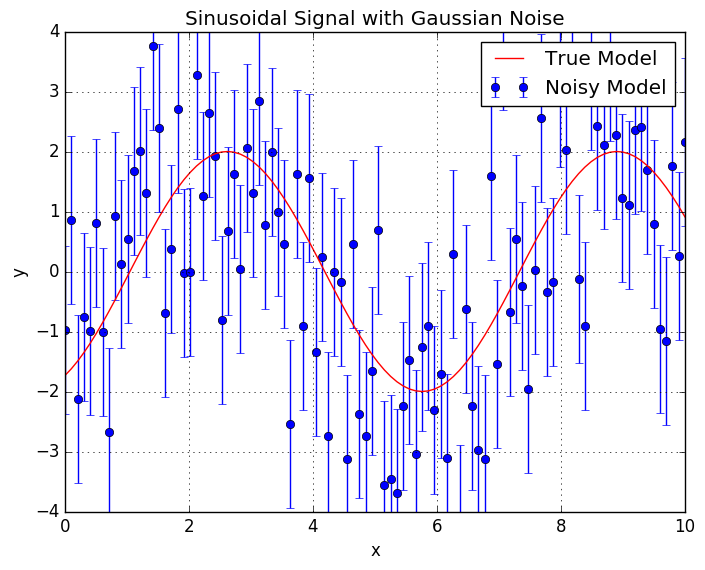

PyObject <matplotlib.legend.Legend object at 0x317685b10>

In [5]:
# Plot the noise model and the true model
errorbar(test_x,test_y,yerr=err_sigma,fmt="o",label="Noisy Model")
plot(test_x,true_y,color="red",label="True Model")

# Format plot
title("Sinusoidal Signal with Gaussian Noise")
xlabel("x")
ylabel("y")

ylim(-2.0*true_amp,2.0*true_amp)
grid(true)
legend()

### Now, we want to write a wrapper function that takes in our fake data and calls the affine-invariant mcmc routine.

---

Note how we gave the MCMC routine our own lnlike function!

In [6]:
function fit_test_model(nsteps::Int,in_data::Array{Float64,2};
    verbose::Bool=true)
    
    global data = in_data
    
    params = [1.0, pi]
    errors = [0.5, 0.5]
    

    return affine_inv_mcmc(nsteps,params,test_model,errors,verbose=verbose,lnlike=lnlike)
end

fit_test_model (generic function with 1 method)

### We're ready to fit!  For simplicity, we'll use the built-in chi-squared function as our log likelihood altough any function, including one with custom priors, can be given by the user.  Specify how many steps we want to run and go!

In [7]:
nsteps = 25000

in_data = [test_x test_y test_yerr]

par_mcmc, lnlike_mcmc, nwalkers, nparam = fit_test_model(nsteps,in_data,verbose=true);

Success: [0.49159755122693627,2.5740946440708905]3452.056320145937
Success: [0.2407890713266312,3.059473512905422]3849.246357513737
Success: [0.5243106955698262,2.800585896347865]3864.3303739738294
Success: [1.3020116564289115,2.7170953709535146]4306.836663662252
Success: [0.943958342830177,2.18980394427871]2429.0249983469157
Success: [0.5698100754954795,2.315810121747881]2981.8591623322204
Number of steps: 5000 acceptance rate: 0.7074666666666667
Number of steps: 10000 acceptance rate: 0.5045333333333333
Number of steps: 15000 acceptance rate: 0.3731333333333333
Number of steps: 20000 acceptance rate: 0.3001333333333333
Number of steps: 25000

### Let's see how we did.  First, we'll approximate where the burn in phase ended, then we'll take the mean and standard deviation of the chains beyond that value to get our results.

In [9]:
iburn = est_burnin(par_mcmc,nwalkers,nparam,nsteps)
@printf "iburn: %d\n" iburn

pavg = mean(vec(par_mcmc[1:nwalkers,iburn:nsteps,1]));
psig = std(vec(par_mcmc[1:nwalkers,iburn:nsteps,1]));
@printf "Amp: %8.4f +/- %8.4f\n" pavg psig
@printf "True amplitude: %8.4f\n" true_amp

pavg = mean(vec(par_mcmc[1:nwalkers,iburn:nsteps,2]));
psig = std(vec(par_mcmc[1:nwalkers,iburn:nsteps,2]));
@printf "Phase: %8.4f +/- %8.4f\n" pavg psig
@printf "True phase: %8.4f\n" true_phase

iburn: 116
Amp:   1.9754 +/-   0.0339
True amplitude:   2.0000
Phase:   1.0598 +/-   0.0322
True phase:   1.0472
